<h1><center>League of Legends - Analysis of Players in North America</center></h1>
 
<img src="../images/logo.png">

## Problem Statement

---
The world of eSports have spearheaded into the mainstream with multiple tech companies such as AMD and Intel jumping into the scene with sponsors and promotions to expand its presense throughout the digital culture. With so many players trying to participate, one must first earn their title by claiming victory. Whether a player is attempting to attract viewers for their brand or a broadcast is narrating a match, we cannot deny that decisions made by players can be analyzed on a macro and micro level to predict the outcome of a match. Here, we want to take those statistics into account and attempt to build a model as well as discover which factors are the most important in determining an outcome of a match by examining team objective completes and individual player statistics.




#### Description of the Game
Below is a map of "Summoner's Rift", the standard arena that players interact with each other. The game is a 5 vs. 5 match with the primary objective of destroying your opponent's base (Nexus). The game is comprised with 3 lanes (Top, Middle, and Bottom) with a wildcard role of being the "Jungler" that roams randomly into their opponents territory to scout or ambush said opponents. The game is played with an isometric view in a point and click environment. There are four main keys (Q, W, E, R) for main champion skills and two summoner skills (D and F keys) which can be customized as the player chooses. Below are two example gameplay screen shots:
<img src="../images/gameplay.png">

#### Champions
League of Legends is a type of game called *Massive Online Battle Arena* (MOBA) where players are connected to a server to "battle" other players of the opposing team. In this game, a player only needs to control one champion which are given a set of skills to be utilized in the match. Example of Champions are shown below:



## Executive Summary

---
We want to load our collect data from a different notebook to begin our analysis of player statistics. As with most datasets, we have to assume that the data will need to be cleaned and formatted before we begin any exploratory analysis. In addition, we need to import all relevant libraries. Our goal is to build a predictive model with the target as being victorious for any match. We quickly see that the data has categorical values as well as many missing values. Since we do cannot impute unknown values, some of the features as well as data points were removed. For the categorical data, we either convert the values from boolean into binary representations or create dummified features to properly account for their data. We also want to identify outliers and make a decision to either include or exclude those values in our model. While it many would consider removing outliers, we decided to keep the outliers and see if our model will perform well even if we have a tiny population of the data showing expected behavior. 

After cleaning the data, we were curious on how players actually perform. We analyzed the distribution of primary player statistics such as kill and death scores obtained through their matches in aggragate. We then looked at the distribution of player ranks from our data. This is important because a player's skill is generally measured by their rank which can affect the win rate distribution. We have to be wary however, that not all players are assumed to play at full strength at all times and occasionally grieving can happen if team morale or attitude heads toward the negative side. With two different analysis examined, we can combined both data and show the average statistics across all ranks. This gives us a general idea of how risk averse or risk-seeking players are. Depending on situation, taking big risks can lead to positive results which can facilitate a victory. However, make the wrong choice and that can cost you the game. We move onto examining champion choices for players per lane choice.

For players familiar with the game, players are able to choose between four roles: Top Lane, Middle Lane, Bottom Lane, or roam in the Jungle (as shown above). Some champions have an absolute popular pick because of the current patch favors their skill set. We recognize that the champion picks between the lanes show little variety and did not offer much information. We proceed to identify champion choices per player rank. Once again we witness the stagnation in variety for choices which is not surprising. Standard players rather high or low ranked, have a tendency to imitate professional players in champion choices. When we noticed the champion choices were not changing, we decided not to examine players in the Diamond, Master, and Challenger ranks because we suspect the top champions will most likely be the same.

Next we want to examine the origin statistics, mainly the kill, death, and assist score specifically, the ratio between them. If a player receives a lot of deaths in any match, there is a high chance that team will lose the match. The negative effect is twofold: by dying, you reward your opponent with resources (gold) in which they will purchase items to increase their strength. In addition, if that player is taken out of play for a specific amount of time (respawn timer) then the game is suddenly lopsided, turning the map into a potential 4 v 5 or even worse. Lastly, if the death occured in laning phase (during the first time minutes of the game) it enables the enemy to steal resources within your team's jungle. One of the many reason players are very attentive to their kill-death-assist ratio is because it shows their decision making and map awareness skills. These factors have a high impact when attempting to lead their team to victory.

With the analysis complete, we attempt to group the KDAs and Dominance factor into their clusters using KMeans. This can potentially give us additional information as a feature and our model can learn better during the modeling phase. 

With all the analysis complete, we proceed with feature engineering. Since we have a lot of categorical data, we need to represent them as a feature properly. We do this by applying the `pd.get_dummies()` method to turn all the categorical data into binary features. We must not forget we must do the same for the clusters we previously created. This is imperative because the clusters, even though are numerical ranges, do not have any ordinal properties. If we simply leave that feature as is, the model will treat it as an ordinal data.

We then proceed with the modeling phase and setting a baseline score. We observe that the score is about 50% which means that if we were to randomly guess an outcome, we should be right half of the time. With this in mind, we need our model to perform better than this otherwise a random guess is more accurate than the model.

### Data Gathering

Please refer [here](API-Data-Gathering.ipynb) for full detail on how data was collected.

### Importing Necessary Libraries and File

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, confusion_matrix, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
import xgboost as xgb


from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

%matplotlib inline

random_state = 42

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [4]:
players_new = pd.read_csv('../data/classic_games_added_champion_and_spells.csv', index_col = 0)

### Exploratory Analysis

There is a lot of data given to us regarding player statistics such as ranking, win rates, champion picks, and many various factors that can contribute to the outcome of a match. League of Legends being a team based game, cannot be simply declared a match is set just by choosing the correct actions at any given time. However, we want to explore the decisions player made individually and as a team in order to claim victory for their matches. We want to start with examining the macro statistics such as team play scores. Then we will slowly examine each individual players and see if they have anything that might indicate an important factor that determines the outcome of a match.

In [5]:
players_new.head()

,assists,champion,deaths,double_kills,first_blood_assist,first_blood_kill,first_inhibitor_assist,first_inhibitor_kill,first_tower_assist,first_tower_kill,...,spell_2,total_damage_dealt_to_champions,total_damage_taken,total_minions_killed,triple_kills,turret_kills,victory,vision_score,wards_killed,wards_placed
10,13,Karma,6,0,False,False,False,False,False,False,...,Flash,15727,14368,7,0,0,False,66,4.0,33.0
11,7,NaN,5,1,False,False,False,False,False,False,...,Flash,21209,17810,207,0,2,False,13,4.0,4.0
12,10,Katarina,10,0,False,False,False,False,False,False,...,Ignite,22110,24273,174,0,0,False,26,4.0,13.0
13,3,Fiora,7,1,False,False,False,False,False,False,...,Teleport,25135,34971,177,0,0,False,14,2.0,7.0
14,5,Khazix,9,0,False,False,False,False,False,False,...,Flash,18415,30333,32,0,1,False,35,9.0,7.0


Lets examine the amount of data that is given to us. The data itself is mostly clean but definitely not complete. In fact, there are an abundant amount of missing data given specific features such as the time based features or statistic deltas. We will have to remove some of the features as well as convert categorical data into binary representations in order to analyze them numerically.

In [6]:
players_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 544214 entries, 10 to 311266
Data columns (total 33 columns):
assists                            544214 non-null int64
champion                           467828 non-null object
deaths                             544214 non-null int64
double_kills                       544214 non-null int64
first_blood_assist                 541598 non-null object
first_blood_kill                   541598 non-null object
first_inhibitor_assist             450618 non-null object
first_inhibitor_kill               450618 non-null object
first_tower_assist                 532424 non-null object
first_tower_kill                   532424 non-null object
game_mode                          544214 non-null object
gold_earned                        544214 non-null int64
gold_spent                         544214 non-null int64
inhibitor_kills                    544214 non-null int64
killing_sprees                     544214 non-null int64
kills                    

For the features below, we want to binarize the data from `True` and `False` types into `0` and `1`. This way we can include them in the models.

In [7]:
convert_to_binary = ['first_blood_assist', 
                     'first_blood_kill', 
                     'first_tower_assist', 
                     'first_tower_kill', 
                     'first_inhibitor_assist', 
                     'first_inhibitor_kill',
                     'victory']

for column in convert_to_binary:
    players_new[column] = players_new[column].map({True: 1, False: 0})

Because we want to include champions that exist and picked, we want to remove players that has missing champion data. We want to proceed the same for summoner spells to give us a complete set of data for these features. It is not possible to impute the champions picked by players and we feel that it is crucial that champion data will play a crucial role in our analysis

In [8]:
players_new = players_new[players_new['champion'].notnull()]
players_new = players_new[players_new['spell_1'].notnull()]

For the following features, we can set the missing information below with 0s because the game will record that statistic if a player or team has satisfied a condition to cause the flag to display `True` within the data from the API. Missing data in this field would imply that player or team did not satisify this condition thus, resulting in either `False` or blank. We can safely replace the blank data with `0` to represent this statistic.

In [9]:
players_new['first_blood_assist'].fillna(0, inplace = True)
players_new['first_tower_kill'].fillna(0, inplace = True)
players_new['first_tower_assist'].fillna(0, inplace = True)
players_new['first_inhibitor_kill'].fillna(0, inplace = True)
players_new['first_inhibitor_assist'].fillna(0, inplace = True)
players_new['first_blood_kill'] = players_new['first_blood_kill'].fillna(0)
players_new['player_rank'] = players_new['player_rank'].fillna('UNRANKED')
players_new['wards_killed'] = players_new['wards_killed'].fillna(0)
players_new['wards_placed'] = players_new['wards_placed'].fillna(0)

After the data is cleaned up, we noticed some oddities within the features. The maximum value for kills for example is extremely high compared to the average. For analysts with game knowledge, we know these numbers do not make much sense as this means an individual player actually achieved 56 kills in a single game which is not impossible but very rare. We can also see the largest killing spree is recorded as 44 which means a player was able to continuously land killing streaks without dying 44 times. That seems highly unlikely but we do not want to discount that possibility. We observed similar behavior with vision score and wards placed. Although we could include the outliers, it might not be very informative for the model to analyze the values that are so far away from the mean. The values for deaths and assist are plausible values since assists are counted based on total team kills assuming player participation exists. As for deaths, it is possible for a single player to fall 29 times in a single game. However, we do not want to remove possible meaningful data so the charts below will exclude the outliers for a more explicit analysis.

In [10]:
players_new.describe().T

,count,mean,std,min,25%,50%,75%,max
assists,466979.0,7.479540,5.579233,0.0,3.0,6.0,11.0,43.0
deaths,466979.0,5.202971,3.071475,0.0,3.0,5.0,7.0,26.0
double_kills,466979.0,0.499894,0.884746,0.0,0.0,0.0,1.0,15.0
first_blood_assist,466979.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
first_blood_kill,466979.0,0.098347,0.297784,0.0,0.0,0.0,0.0,1.0
first_inhibitor_assist,466979.0,0.186694,0.389666,0.0,0.0,0.0,0.0,1.0
first_inhibitor_kill,466979.0,0.067693,0.251218,0.0,0.0,0.0,0.0,1.0
first_tower_assist,466979.0,0.070179,0.255448,0.0,0.0,0.0,0.0,1.0
first_tower_kill,466979.0,0.078158,0.268420,0.0,0.0,0.0,0.0,1.0
gold_earned,466979.0,10031.372055,3788.404121,665.0,7468.0,9818.0,12408.0,32203.0


#### Kills, Death, and Assist Distributions

We begin by examining the distribution of Kills, Deaths, and Assists for players. This will tell us the behavior of players and how many of them are risk adverse or risk takers. Cautious players might play reserved and focused on objectives while blood thirsty players will aim to cause chaos during the match. The decision of the players can either benefit or burden the team depending if the situation calls for that action. Since we cannot accuracy measure human pyschology, our best analysis will be the graphs showing how majority of the players behave with these statistics.

In [11]:
def distribution(threshold, column, bins): # defining a function to take 2 variables to generate a historgram
    
    plt.figure(figsize = (12,7)) # setting default graph size
    
    graph = players_new[players_new[column] < threshold][column] # setting default variable in the function call 
                                                                 # specific features 
    
    graph.hist(bins = bins, 
               grid = False)

    mean = graph.mean() # setting mean value
    sd = graph.std() # setting default standard deviation value
    sd_above_mean = mean + sd # setting standard deviation above the mean
    sd_below_mean = mean - sd # setting standard deviation below the mean

    plt.axvline(mean,  # this code generates a line for the mean of the distribution
                color='r', 
                linestyle='solid', 
                linewidth = 5, 
                label = f'Mean of {str(column).title()}')

    plt.axvline(sd_above_mean, # this code generates a line for one standard deviation above the mean
                color='cyan', 
                linestyle='solid', 
                linewidth = 5, 
                label = f'One Standard Deviation Above Mean of {str(column).title()}')

    plt.axvline(sd_below_mean, # this code generates a line for one standard deviation below the mean
                color='magenta', 
                linestyle='solid', 
                linewidth = 5, 
                label = f'One Standard Deviation Below Mean of {str(column).title()}')


    plt.xlabel(f'Player {str(column).title()}', fontsize = 16) # setting x-axis label
    plt.ylabel('Number of Players', fontsize = 16) # setting y-axis label
    plt.title(f'Player {str(column).title()} Distribution for all Games', fontsize = 30) # setting title
    plt.legend(fontsize = 14) # enabling legends for the verticle plot lines

    plt.tight_layout();

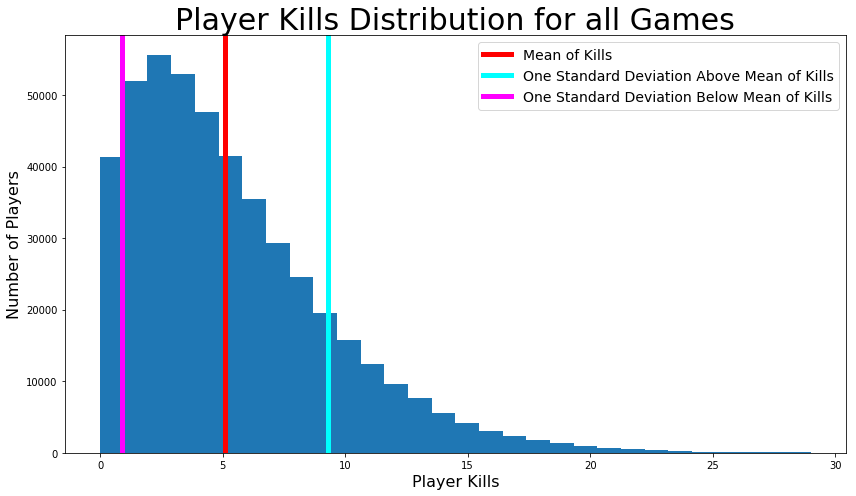

In [12]:
distribution(30, 'kills', 30)

In most matches, having a very dominating game is quite difficult as most players are risk adverse and the penalty of resulting a death is quite high. Most players tend to play passively until past the 10 minute mark and most matches end with about a combine team kill of 15-20 at most. The graph above is quite expected as most players, such as supports, do not contribute to killing an opponent but resort to assisting as a source of income during the match. 

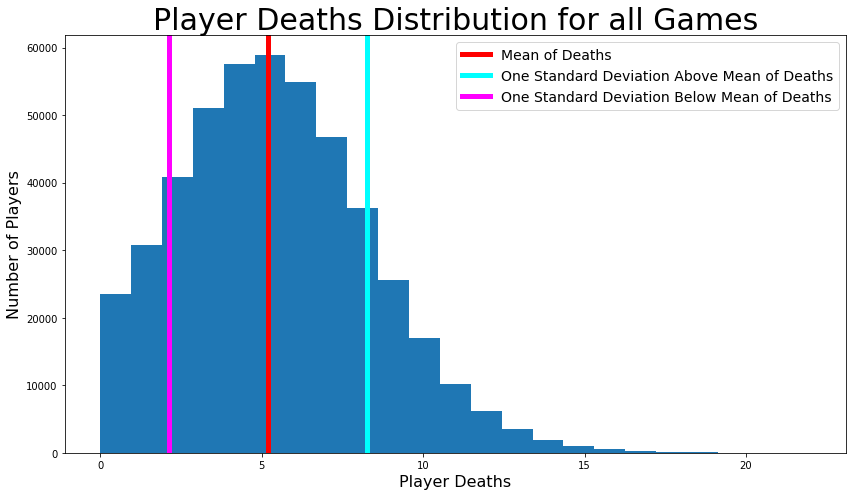

In [13]:
distribution(23, 'deaths', 23)

A death means that a team will temporarily lose a member for an amount of time that scales to increase that the game prolongs. That means, a death early game (between 0-10 minutes) have less impact compared to mid to late game (above 10 minutes). That is because respawn timers are dramatically increased as to punish players that make high risk decisions and fail to execute them without death. Generally, if players achieve a death of 5 or above are regarded as the main cause to a match loss be(ause that player is not contributing to the team and provide resource (in form of gold reward for the opponent) which will give the enemy team a large advantage over time. It is surprising to see that the average deaths for any player falls around 6 since that amount of deaths certainly will decide a match's outcome. 

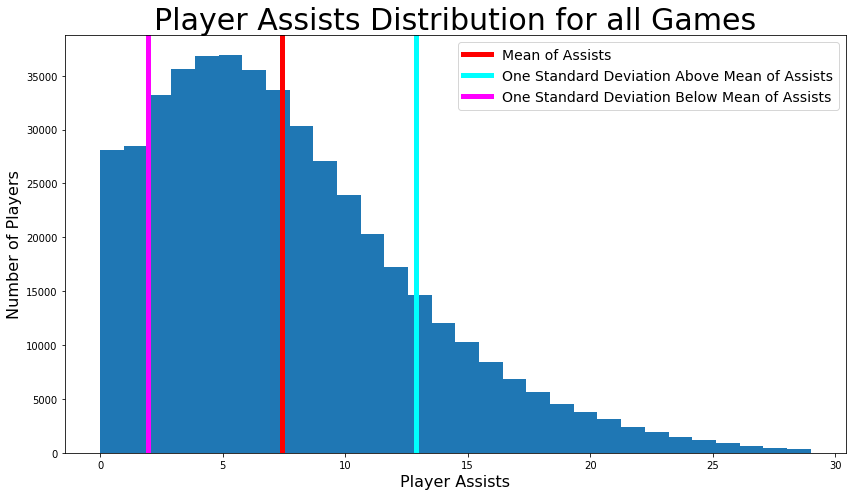

In [14]:
distribution(30, 'assists', 30)

Player assists adds to kill contributions and has lower reward level than an actual kill but it shows participation of the team. Players that chooses support will utilize this method as a primary source of income because other members will need more resource to have a threat to their opponent. Generally, a support champion's skillset is designed to perform optimally without much need of resources so the other members can concentrate of maximizing their income to have a stronger impact in the match.

#### Player Rank Analysis
---
Within the data collected, we are given a player's rank. Within League of Legends, rank is used to determine a skill level and generally are correlated with performance. One can say the higher a players rank, the more skill that player is expected to show whether it is game mechanics or strategies. A player's experience unfortunately will not factor into their rank simply because there are players that exist that never wanted to be gauged competitively or simply want to casually play the game. On the professional level, players must achieve the Challenger rank. According to a league [metric](https://www.leagueofgraphs.com/rankings/rank-distribution), only 0.2% of the players **with ranking** belong to challenger. Because there are many players that do not get evaluated in the ranking system, the actual amount of Challenger rank is about 200 players combined worldwide [(source)](https://dotesports.com/league-of-legends/news/riot-games-reveals-challenger-size-for-each-league-of-legends-region).

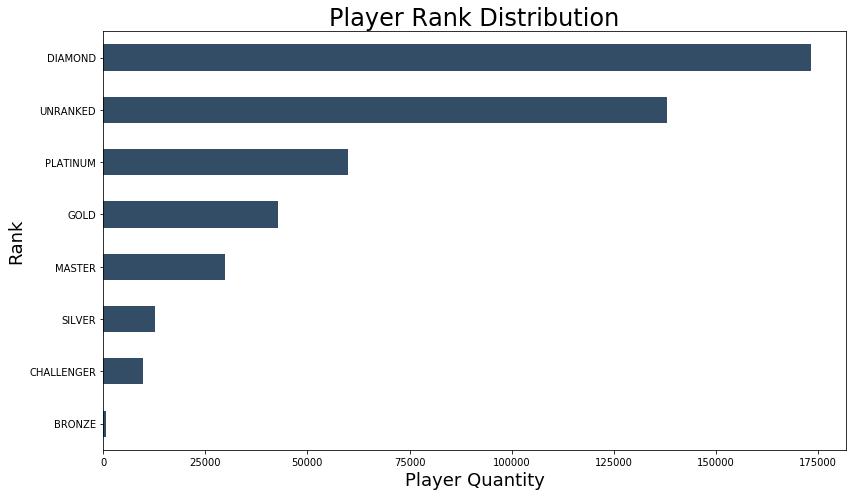

In [15]:
plt.title('Player Rank Distribution', fontsize = 24)
ax = players_new['player_rank'].value_counts().sort_values().plot(kind = 'barh', figsize = (12, 7), color = (.2,.3,.4))

plt.xlabel('Player Quantity', fontsize = 18)
plt.ylabel('Rank', fontsize = 18)


plt.tight_layout();

We want to combine our analysis with with the total mean of Kills, Deaths, And Assist per player rank. We witness that Bronze Ranked players appears to be more reckless and have the highest average compared to other players. The data could be a bit skewed because of the distribution of players rank is not even as seen above. The kills and assists score for the other ranks appear to be close to each other regardless of their respective brackets. The second highest death score appears to belong to Silver Ranked players with Challenger players having the lowest death count. But because of how the averages are so close to each other, there is not much information given here.

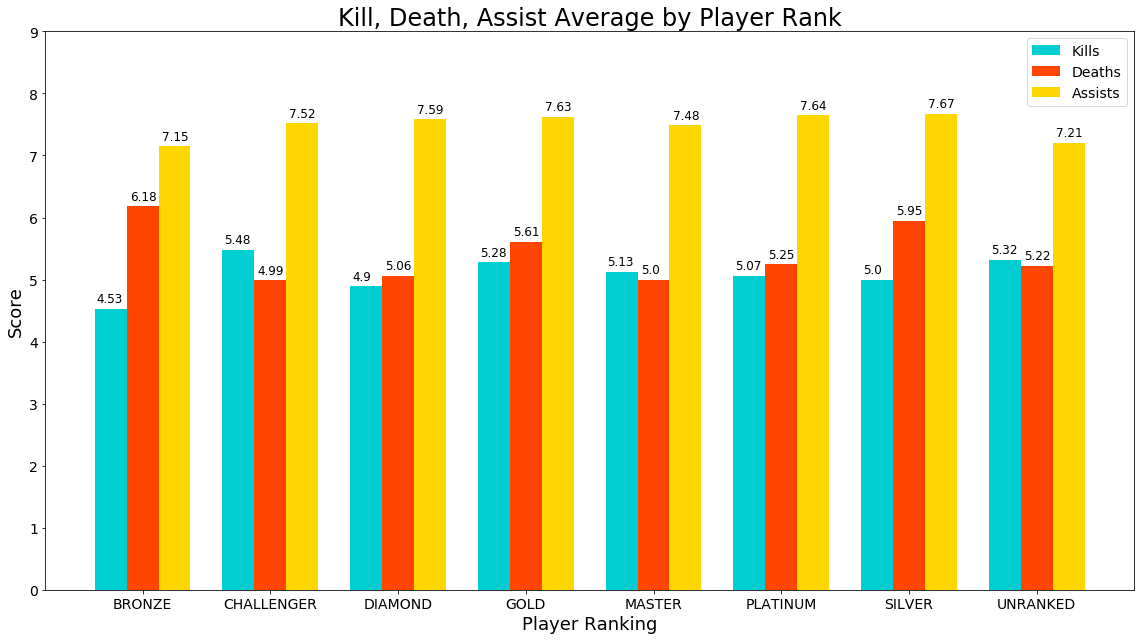

In [16]:
plt.figure(figsize = (16,9))  # setting graph size
ax = plt.subplot(111) # defining subplot presets

labels = list(players_new.groupby('player_rank')['deaths'].mean().index) #setting xtick labels in the order of the series index
location = np.arange(len(labels)) # setting the placement locations for the labels
width = .25 # size of the bars

ax.bar(location - width, players_new.groupby('player_rank')['kills'].mean(), # defining the kill score mean of the bar graph
       width = width, 
       color = 'DarkTurquoise', 
       label = 'Kills')
ax.bar(location, players_new.groupby('player_rank')['deaths'].mean(), # defining the death score mean of the bar graph
       width = width, 
       color = 'OrangeRed', 
       label = 'Deaths')
ax.bar(location + width, players_new.groupby('player_rank')['assists'].mean(), # defining the assist score mean of the bar graph
       width = width, 
       color = 'Gold', 
       label = 'Assists')


# the following code prints the text of actual mean value round to the second decimal place on top of the bar
# we limited the decimals to two because we did not want the number to extend past the width of the bar
for i in location: # the first loop is for the kill score mean
    ax.text(i - width - .11, 
            players_new.groupby('player_rank')['kills'].mean()[i] + .1, 
            str(round(players_new.groupby('player_rank')['kills'].mean()[i], 2)), fontsize = 12)

for i in location: # the second loop is for the death score mean
    ax.text(i-.1, 
            players_new.groupby('player_rank')['deaths'].mean()[i] + .1, 
            str(round(players_new.groupby('player_rank')['deaths'].mean()[i], 2)), fontsize = 12)

for i in location: # the third loop is for the assist score mean
    ax.text(i + width - .1, 
            players_new.groupby('player_rank')['assists'].mean()[i] + .1, 
            str(round(players_new.groupby('player_rank')['assists'].mean()[i], 2)), fontsize = 12)
    


ax.set_ylabel('Score', fontsize = 18) # setting the y-label for the graph
ax.set_yticklabels(range(10), fontsize=14) # extended the maximum y-axis limit to give more display area for the legend

ax.set_xticks(location) # setting the x-label for the graph
ax.set_xticklabels(labels, fontsize = 14)
ax.set_xlabel('Player Ranking', fontsize = 18) # setting the x-label for the graph
ax.set_yticks(range(10))

ax.set_title('Kill, Death, Assist Average by Player Rank', fontsize = 24)


plt.legend(fontsize = 14)
plt.tight_layout();

plt.savefig('../graphs/KDA_by_rank.png')

#### Seperating Players into their Ranks and Identifying Outcome of Matches
---
Below we are creating a filter as well a function to show the distribution of champion selection for each rank bracket. The graph will show which champions are the top 5 most and least picked for the player's rank. We can see how different rankings will have different choices in their preferred "meta" game. The term "meta" refers to the current trend that a particular champion is populat due to the current patch increasing the strength and utility of that champion. However, with each patch, the selection changes as Riot will continuous change the attributes of the champions, therefore increasing the diversity of picks for games.

In [17]:
bronze_players = (players_new['player_rank'] == 'BRONZE')
silver_players = (players_new['player_rank'] == 'SILVER')
gold_players = (players_new['player_rank'] == 'GOLD')
platinum_players = (players_new['player_rank'] == 'PLATINUM')
diamond_players = (players_new['player_rank'] == 'DIAMOND')
master_players = (players_new['player_rank'] == 'MASTER')
challenger_players = (players_new['player_rank'] == 'CHALLENGER')
casual_players = (players_new['player_rank'] == 'UNRANKED')

games_won = (players_new['victory'] == 1)
games_lost = (players_new['victory'] == 0)

bottom_lane = (players_new['lane'] == 'BOTTOM')
middle_lane = (players_new['lane'] == 'MIDDLE')
top_lane = (players_new['lane'] == 'TOP')
jungle = (players_new['lane'] == 'JUNGLE')

We created a function below to streamline the visualization creation for player rank and lane choice for any particular match. The visualization will display the champion picks for each category (rank or lane choice) and the outcome of the match. We believe that there could be a relationship between which champions players choose and how the match proceeds. We begin with macro decisions which is choosing the lane assignment. Generally a team will discuss during the champion selection on which lane they wish to choose. Then the players will decide on a champion that fits the lane. 

In [18]:
def comparison(rank, title1, title2): # the function will take two variables to define the rank of choice and the title
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16,9)) # setting default size and orientation of the graphs
    
    # we are setting two label variables below in preparation for modifying x-ticks and y-ticks
    labels_1 = players_new[rank & games_won]['champion'].value_counts().head(10).sort_values().index
    labels_2 = players_new[rank & games_lost]['champion'].value_counts().head(10).sort_values().index
    
    # the location of the ticks will be determined by the length of the labels from above
    location_1 = np.arange(len(labels_1))
    location_2 = np.arange(len(labels_2))
    
    # setting default with of the bars
    width = .25
    
    
    # The following will set the parameters for the left part of the horizontal bar chart. We will split chart into two pieces
    # with the left chart denoting the victorious outcome and the right being defeated. 
    
    ax[0].set_title(title1, fontsize = 18) # setting title for the left chart
    
    # For the horizontal chart, we define the x-axis to be the frequency of occurences and the y-axis to be the names.
    # Thus we set the y-ticks to be the index of the data and the x-ticks to be the count in reverse order to display maximum
    # value. 
    ax[0].barh(players_new[rank & games_won]['champion'].value_counts().head(10).sort_values().index,
               players_new[rank & games_won]['champion'].value_counts().head(10).sort_values())
    ax[0].set_xlabel('Chosen Frequency', fontsize = 20)
    ax[0].set_ylabel('Champion Names', fontsize = 20)
    ax[0].set_yticklabels(players_new[rank & games_won]['champion'].value_counts().head(10).sort_values().index, fontsize = 14)
    
    
    # Because of the count having a variety of frequency range, we want to create a dynamic x-tick step filter where the 
    # steps change based on the maximum range of frequent occurence. 
    if max(players_new[rank & games_won]['champion'].value_counts().head(10)) > 3000: # for frequency over 3000, the steps will
                                                                                      # 500 steps per tick
        ax[0].xaxis.set_ticks(np.arange(0, 
                                    max(players_new[rank & games_won]['champion'].value_counts().head(10)) + 1, 
                                    500))
   
    elif max(players_new[rank & games_won]['champion'].value_counts().head(10)) > 1500: # for frequency between 3000 and 1501, 
                                                                                        # the steps will 250 steps per tick
                                                                                                                                                                        
        ax[0].xaxis.set_ticks(np.arange(0, 
                                    max(players_new[rank & games_won]['champion'].value_counts().head(10)) + 1, 
                                    250))

    elif max(players_new[rank & games_won]['champion'].value_counts().head(10)) > 500: # for frequency between 1500 and  501, 
                                                                                       # the steps will 50 steps per tick
        ax[0].xaxis.set_ticks(np.arange(0, 
                                    max(players_new[rank & games_won]['champion'].value_counts().head(10)) + 1, 
                                    50))
    
    elif max(players_new[rank & games_won]['champion'].value_counts().head(10)) > 250: # for frequency between 500 and  251, 
                                                                                       # the steps will 30 steps per tick
        ax[0].xaxis.set_ticks(np.arange(0, 
                                    max(players_new[rank & games_won]['champion'].value_counts().head(10)) + 1, 
                                    30))         
    
    elif max(players_new[rank & games_won]['champion'].value_counts().head(10)) > 150: # for frequency between 250 and  151, 
                                                                                       # the steps will 25 steps per tick
        ax[0].xaxis.set_ticks(np.arange(0, 
                                    max(players_new[rank & games_won]['champion'].value_counts().head(10)) + 1, 
                                    25)) 
    
    else: # any frequency less than 151 will be a single unit per tick
        ax[0].xaxis.set_ticks(np.arange(0, 
                                    max(players_new[rank & games_won]['champion'].value_counts().head(10)) + 1, 
                                    1))
    
    for i in location_1: # this code creates a numerical text at the end of each bar to show the exact frequency of occurence
        ax[0].text(players_new[rank & games_won]['champion'].value_counts().head(10).sort_values()[i] + .1, 
                   i,
                   str(players_new[rank & games_won]['champion'].value_counts().head(10).sort_values()[i]), 
                   fontsize = 9)
    
    ax[1].set_title(title2, fontsize = 18)
    ax[1].barh(players_new[rank & games_lost]['champion'].value_counts().head(10).sort_values().index,
               players_new[rank & games_lost]['champion'].value_counts().head(10).sort_values())
    ax[1].set_xlabel('Chosen Frequency', fontsize = 20)
    ax[1].set_ylabel('Champion Names', fontsize = 20)
    ax[1].set_yticklabels(players_new[rank & games_lost]['champion'].value_counts().head(10).sort_values().index, fontsize = 14)
    
    if max(players_new[rank & games_won]['champion'].value_counts().head(10)) > 3000: # for frequency over 3000, the steps will
                                                                                      # 500 steps per tick
        ax[1].xaxis.set_ticks(np.arange(0, 
                                    max(players_new[rank & games_lost]['champion'].value_counts().head(10)) + 1, 
                                    500))
    
    elif max(players_new[rank & games_lost]['champion'].value_counts().head(10)) > 1500: # for frequency between 3000 and 1501, 
                                                                                         # the steps will 250 steps per tick
        ax[1].xaxis.set_ticks(np.arange(0, 
                                    max(players_new[rank & games_lost]['champion'].value_counts().head(10)) + 1, 
                                    250))
    elif max(players_new[rank & games_won]['champion'].value_counts().head(10)) > 500: # for frequency between 1500 and  501, 
                                                                                       # the steps will 50 steps per tick
        ax[1].xaxis.set_ticks(np.arange(0, 
                                    max(players_new[rank & games_lost]['champion'].value_counts().head(10)) + 1, 
                                    50))
    elif max(players_new[rank & games_won]['champion'].value_counts().head(10)) > 250: # for frequency between 500 and  251, 
                                                                                       # the steps will 30 steps per tick
        ax[1].xaxis.set_ticks(np.arange(0, 
                                    max(players_new[rank & games_lost]['champion'].value_counts().head(10)) + 1, 
                                    30))
    elif max(players_new[rank & games_won]['champion'].value_counts().head(10)) > 150: # for frequency between 250 and  151, 
                                                                                       # the steps will 25 steps per tick
        ax[1].xaxis.set_ticks(np.arange(0, 
                                    max(players_new[rank & games_lost]['champion'].value_counts().head(10)) + 1, 
                                    25))    
    else: # any frequency less than 151 will be a single unit per tick
        ax[1].xaxis.set_ticks(np.arange(0, 
                                    max(players_new[rank & games_lost]['champion'].value_counts().head(10)) + 1, 
                                    1))

    for i in location_2: # this code creates a numerical text at the end of each bar to show the exact frequency of occurence
        ax[1].text(players_new[rank & games_lost]['champion'].value_counts().head(10).sort_values()[i] + .1, 
                   i,
                   str(players_new[rank & games_lost]['champion'].value_counts().head(10).sort_values()[i]), 
                   fontsize = 9)
    
    
    plt.tight_layout();

#### Identifying Popular Champion Picks for Specific Lanes
---
Here we want to examine which champions are populat picks for players given a specific role. As we know, League of Legends is a a team based game with a 5 vs. 5 map setting. Each player is given a role for game and must adhere to their role in order to efficiently procure a victory. 

##### Bottom Lane
---
It appears that Ezreal, Caitlyn, Thresh, Sivir, and Lucian were the top 5 most popular bottom lane champion pick. This lane is generally a 2 v 2 scenario where there is a support champion with a marksmen. In terms of win and lose comparison, besides Sivir, games were lost while pick the other four champions. This could mean that those four champions while popular, do not contribute to increasing win rate as much if not at all. Since the majority of our player population within the data are Diamond ranked players, we can assume skill is not a factor here but rather there are other underlying criteria to determine the outcome of a match.

<img src="../images/Bottom_lane.png">

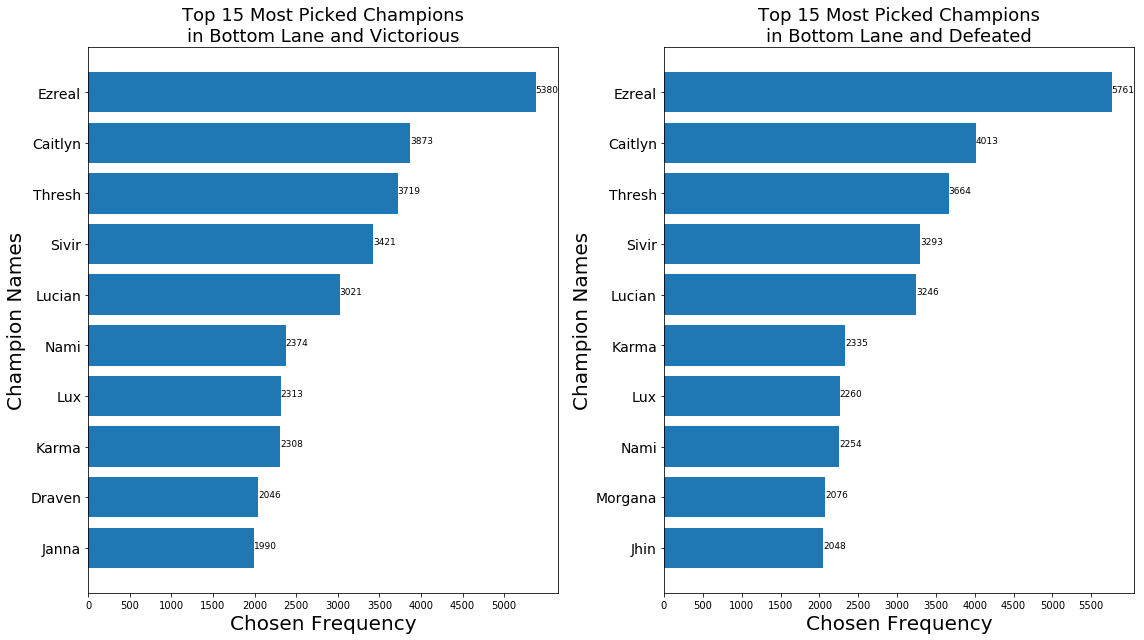

In [19]:
comparison(bottom_lane, 
           'Top 15 Most Picked Champions\nin Bottom Lane and Victorious',
           'Top 15 Most Picked Champions\nin Bottom Lane and Defeated')

##### Top Lane
---
Going in an opposite direction, we see the top 3 champions being Aatrox, Riven, and Darius respectively before the change in order of results in the win and lose analysis. This lane is generally suited for close range combat style champions that have a high amount of sustain so the player can recover damage received and prolong their presense. Here we have a similar situation as bottom lane where even though a champion is popular, it does not contribute to more wins than lose for their matches

<img src="../images/top_lane.png">

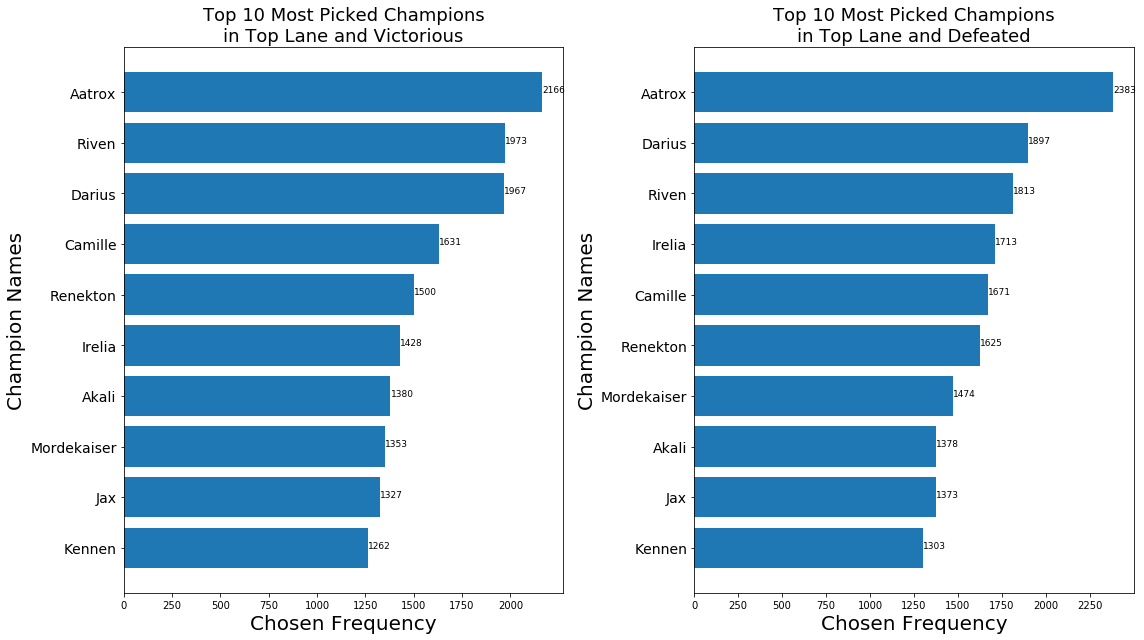

In [20]:
comparison(top_lane, 
           'Top 10 Most Picked Champions\nin Top Lane and Victorious',
           'Top 10 Most Picked Champions\nin Top Lane and Defeated')

##### Middle Lane
---
The middle lane often regarded as the most passive lane in League of Legends because players usually do not initiate any form of aggression aside from occasional zone check. This role typically belongs to champions that rely of high damaging skills that can be executed in short succession. Players in this role usually stay in this lane until after the 10-15 minute mark before they start to aid other lanes with their objectives. If however a player is having a dominant experience with their matchup, they can roam to another lane early and agress on their opponent to take objectives. It is interesting how both victorious and defeated outcomes tend to have the same champion of choice for various players.

<img src="../images/mid_lane.png">

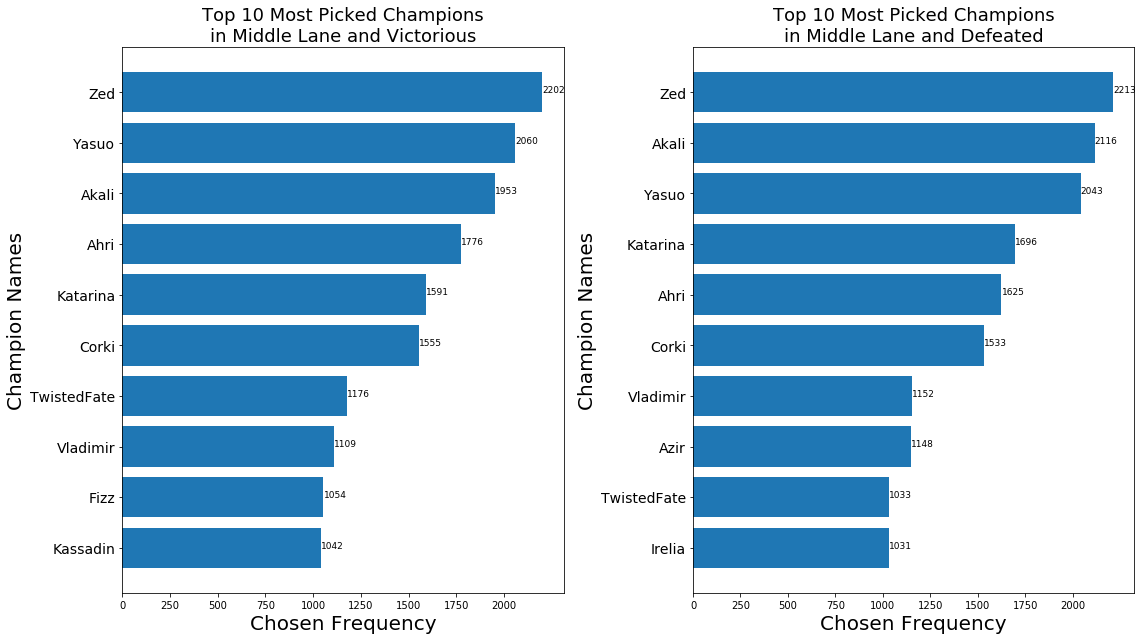

In [21]:
comparison(middle_lane, 
          'Top 10 Most Picked Champions\nin Middle Lane and Victorious',
          'Top 10 Most Picked Champions\nin Middle Lane and Defeated')

##### Jungler
---
This role is probably the most difficult profession to play because of the expectation of the player to roam in clandestine around the map in hopes of ambush. In addition, this role is required to capture secondary objectives for the team without being detected while retrieving reconnaissance. The champion type for this role are typically assassin type champions that have high mobility and occasionally stealth. In the opposite spectrum, players occasionally decide to play a tank style jungler (tanks are champions that can block damage for the team). The style of choice varies depending on how the Top lane plays and the Jungler will complement that choice. In essense, both Top and Jungler will need to coordinate frequently in matches to excel. In this distribution, the first and second most picked junglers appear to be assassins followed by two tanks. While    Lee Sin does not appear to have much influence in match outcomes, Kha'zix shows to be a much more effective assassin. We believe it could be due to the ability of stealth which Kha'zix possess.

<img src="../images/jungle.png">

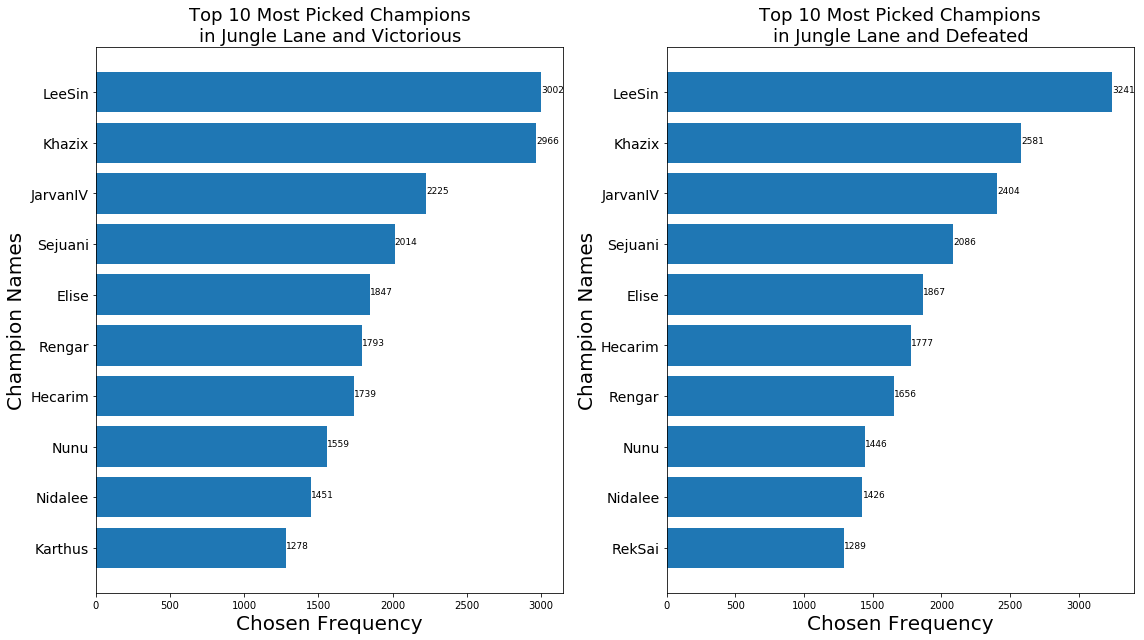

In [22]:
comparison(jungle, 
          'Top 10 Most Picked Champions\nin Jungle Lane and Victorious',
          'Top 10 Most Picked Champions\nin Jungle Lane and Defeated')

#### Player Ranks and their Champion of Choice
---
Generally this game will have "meta" moments which means a specific pool of champions will be constantly picked because the current patch either gave those set of champions a power boost or their old pool were weakened. Nonetheless we want to see how players in their respective ranks choose their standard picks and their outcomes.

##### Unrank Players
---
Players in this bracket (like us) are more casual where we play for leisure and do not try to climb the ranking ladder. However, we still choose our champions based on the current state of the game where we know certain champions have greater utility than others and until Riot (the company that made League of Legends) decide to change that with a patch. The distribution of champion choices might not differ much. We can see the list of champions between wins and losses do not have much variety with only some champions shifting positions.

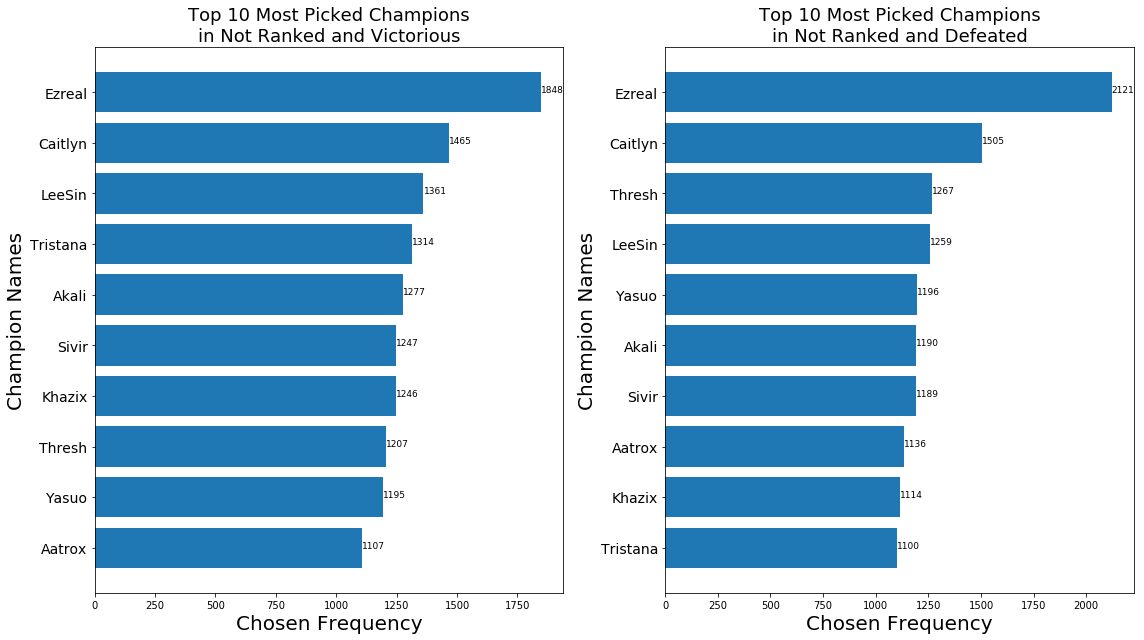

In [23]:
comparison(casual_players, 
          'Top 10 Most Picked Champions\nin Not Ranked and Victorious',
          'Top 10 Most Picked Champions\nin Not Ranked and Defeated')

##### Bronze Ranked Players
---
Bronze is the lowest bracket in terms of how Riot grades skill (this is no longer the case as there is a new rank call Iron being introduced but more will be discussed later). It is surprising that a support champion is the top pick for players in this bracket as most would rather enjoy playing marksmen or more aggressive roles. However, we recognize that the amount of bronze ranked players were severely lacking in our dataset so the true distribution could change.

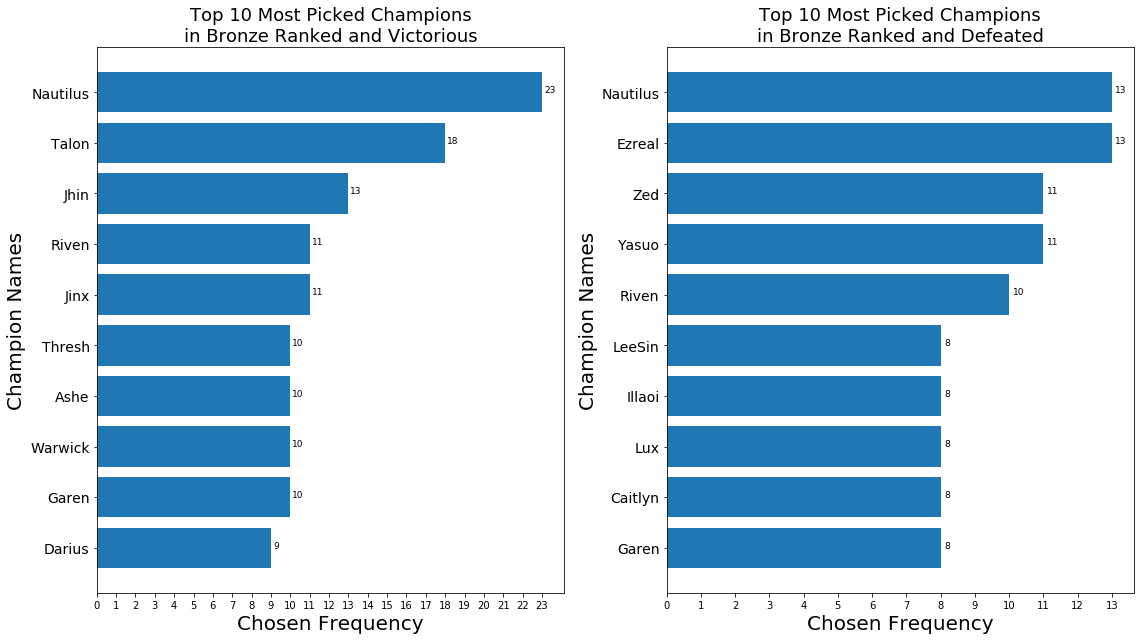

In [24]:
comparison(bronze_players, 
          'Top 10 Most Picked Champions\nin Bronze Ranked and Victorious',
          'Top 10 Most Picked Champions\nin Bronze Ranked and Defeated')

##### Silver Ranked Players
---
Being in silver ranked has been a stigma since the inception of the game where players always claim they are forever stuck in this bracket due to incompetency of their teammates. We observe here that for victorious outcomes, a support champion was preferred followed by a marksmen but in the losing side, the champion of choice was a marksmen followed by a support type. 

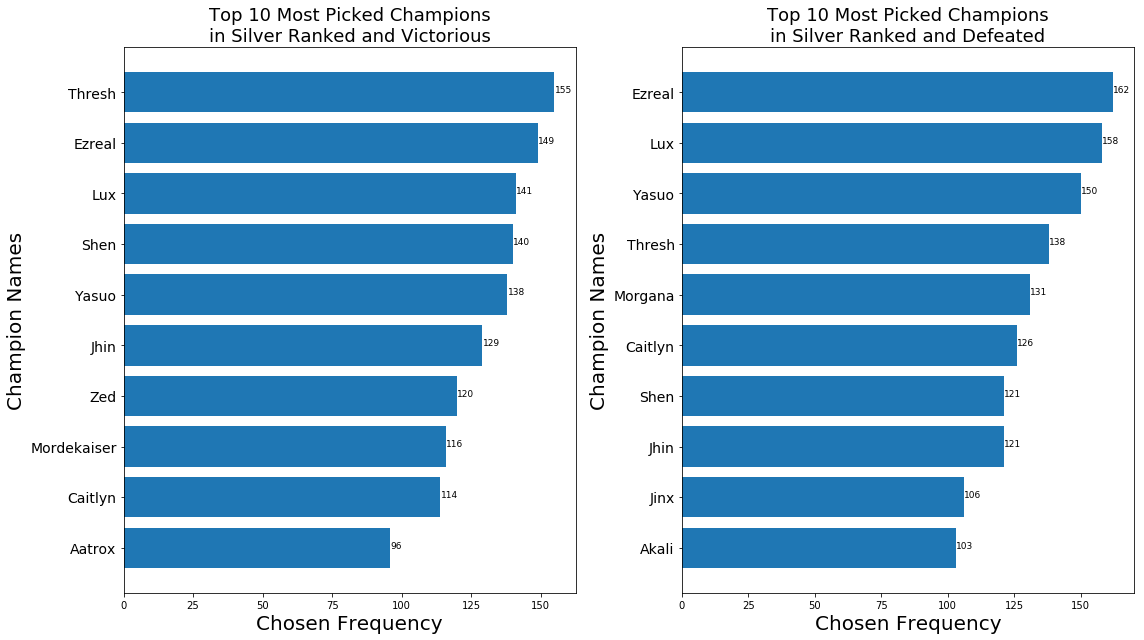

In [25]:
comparison(silver_players, 
           'Top 10 Most Picked Champions\nin Silver Ranked and Victorious',
           'Top 10 Most Picked Champions\nin Silver Ranked and Defeated')

##### Gold Ranked Players
---
We achieve a rank threshold here were the skill cap from Silver to Gold is quite different. The top 3 of this list was shuffled between win and lose with a support being the most picked champion and claiming victorious while picking a marksmen appears to be not very effective. Between Bronze to Gold, we have not seen much of a difference for champion variety and we can see the meta factor in full effect.

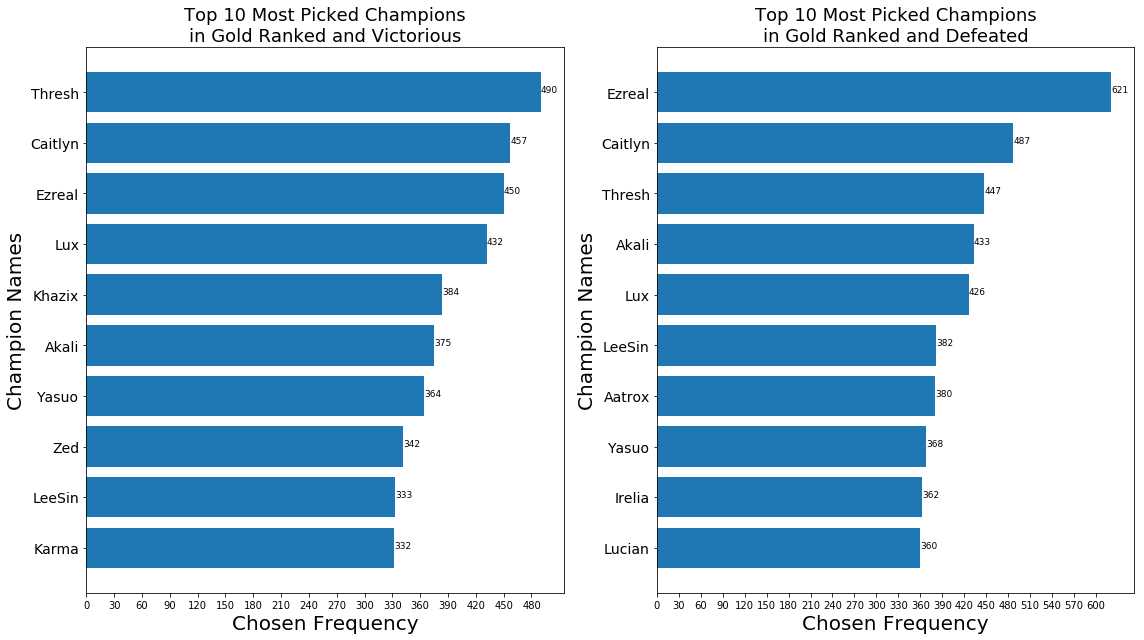

In [26]:
comparison(gold_players, 
          'Top 10 Most Picked Champions\nin Gold Ranked and Victorious',
          'Top 10 Most Picked Champions\nin Gold Ranked and Defeated')

##### Platinum Ranked Players
---
We reached this far down and Ezreal is still the top pick followed by Caitlyn. For those who are familiar with those champions, those champions have very high damage output as well as mobility which is highly preferred for players in the bottom lane. As players know, abilities that hinder movement or lacks skill to trick their opponent, their presence would be over shadowed as the game progresses. As skills of players increase, they recognize these important factors and will gravitate toward these picks.

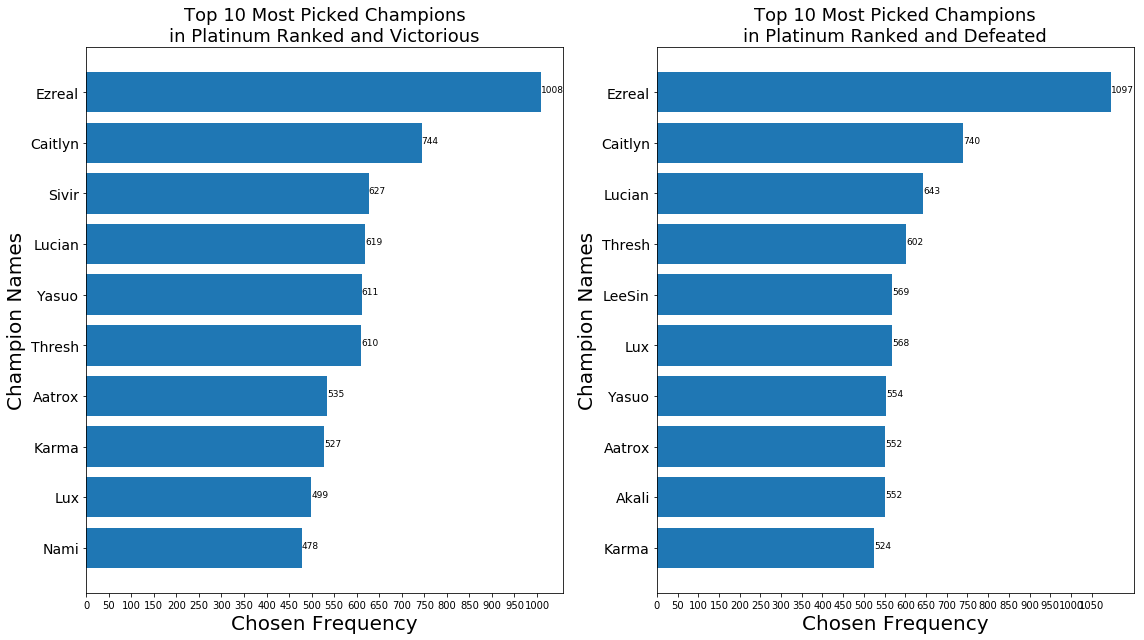

In [27]:
comparison(platinum_players, 
           'Top 10 Most Picked Champions\nin Platinum Ranked and Victorious',
           'Top 10 Most Picked Champions\nin Platinum Ranked and Defeated')

##### Diamond, Master, and Challenger Ranked Players
---
As we continue our analysis, there is little to no deviation or information of interest for the following ranked players because the distributions do not change. Sadly, even though we have 140+ champions available to choose from, the idea of "following the herd" applies with this game too. Most players will see how to professionals play and imitate their play style or picks. 

### Utilizing KMeans Clustering Method

We want to create a feature called KDA (Kill/Death/Assist) ratio. One of the most analyzed statistic of players is looking at the value of the KDA a player inhibits. Generally, if a player is performing poorly, their KDA will be low and can be isolated as a negative factor for a team. Similarly, we can add another feature called the dominance factor that penalizes deaths more heavily than kills. The penalty will have a more significant flag on players that perform purely with scores going into negative values.

In [28]:
# Account for case when deaths = 0, then KDA calculations treats death = 1
players_new['death_kda'] = players_new['deaths'].map(lambda x: 1 if x == 0 else x)

# Creating new features call KDA which is the ratio of kills. deaths, and assists
players_new['kda'] = np.round((players_new['kills'] + players_new['assists']) / players_new['death_kda'], 3)
players_new['kda'].fillna(0, inplace = True)

# Calculation for dominance factor can be found at https://leagueoflegends.fandom.com/wiki/Kill_to_Death_Ratio
players_new['dominance_factor'] = (players_new['kills'] * 2) - (players_new['deaths'] * 3) + players_new['assists']

In [29]:
# because KMeans uses distance as a determant for its calculation, we will have to standardize the data before input the 
# features into the model
sc = StandardScaler()
sc_kda_dom = sc.fit_transform(players_new[['kda', 'dominance_factor']])

In [ ]:
silhou_k = []
inertia_k = []

for i in range(2, 5):
    km = KMeans(n_clusters=i, n_jobs = -1, verbose = 2)
    km.fit(sc_kda_dom)
    silhou_k.append(silhouette_score(sc_kda_dom, km.labels_))
    inertia_k.append(km.inertia_)

In [ ]:
kmeans_values = pd.DataFrame({'silhouette': silhou_k, 'inertia': inertia_k}, index = range(2,17))

data1 = kmeans_values['silhouette']
data2 = kmeans_values['inertia']

fig, ax1 = plt.subplots(figsize=(10,10))

ax1.set_xlabel('K Clusters', fontsize = 16)
ax1.set_ylabel('Silhouette Score', color = 'tab:blue', fontsize = 16)
ax1.plot(data1, color = 'tab:blue')
ax1.tick_params(axis = 'y', labelcolor = 'tab:blue')

ax2 = ax1.twinx()

ax2.set_ylabel('Inertia Score', color = 'tab:red', fontsize = 16)
ax2.plot(data2, color = 'tab:red')
ax2.tick_params(axis = 'y', labelcolor = 'tab:red')

plt.title('Comparion of Silhouette and Inertia Score for KMeans Model', fontsize = 20)
plt.tight_layout()

In [30]:
km = KMeans(n_clusters=7)
km.fit(sc_kda_dom)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [ ]:
silhouette_score(sc_kda_dom, km.labels_)

In [31]:
players_new['kda_dominance_cluster'] = km.labels_

### Feature Engineering

With most of the data analyzed, we can proceed to engineer some features that can facilitate our modeling below. We want to identify current features that we can dummify or interact.

In [32]:
players_new = pd.get_dummies(players_new, columns = ['champion', 
                                                     'spell_1', 
                                                     'spell_2', 
                                                     'player_rank', 
                                                     'role', 
                                                     'lane', 
                                                     'kda_dominance_cluster'])

Because we dropped some data above for players that did not have champion selection data, we are resetting the index just to be consistent with the row numbering scheme. This usually is not a major issue when fitting a model but it can get confusing when viewing the amount of datapoints using the index as a reference.

In [33]:
players_new.reset_index(inplace = True, drop = True)

We are instantiating a variable to the show the correlation between all other features against our target variable, the outcome of the match. This is useful for feature selection performed below by creating thresholds in form of absolute value of the correlation in order to determine which features to filter out during the modeling.

### Modeling Preparation

We are going to set a standard instantiation for all of the models here so that they only need to be called when needed instead of recalling every section. In addition we want to define a function to search for the best parameters as well as best model score.

In [34]:
lr = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
bg = BaggingClassifier()
rf = RandomForestClassifier()
svc = SVC(gamma = 'scale', probability=True)
xg = xgb.XGBClassifier()

The function below was imported from the third project involving analyzing and predict Reddit forum posts. Because our problem is also a classification, we felt it was appropriate to bring this function over to display metrics of our model.

In [35]:
def metrics(y_true, y_pred, model, X_test):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel() # defines the value for confusion matrix
    acc = model.score(X_test, y_test)  #calculates the accuracy for the model
    mis = 1 - acc # calculates the misclassication for the model
    spec = tn / (tn+fp) # calculates the specificity for the model
    sens = tp / (tp+fn) # calculates the sensitivity for the model
    prec = tp / (tp+fp) # calculates the precision for the model

    # Print results for metrics
    print(f'The accuracy for the test data for this model is {round(acc,3)}')
    print(f'The misclassification for the test data for this model is: {round(mis,3)}')
    print(f'The specificity for the test data for this model is: {round(spec,3)}')
    print(f'The sensitivity for the test data for this model is: {round(sens,3)}')
    print(f'The precision for the test data for this model is: {round(prec,3)}')

The function below is taken from our third project, The Reddit Forum Analysis, which was borrowed from our lecture. This function's primary output is generating the Receiver Operating Characteristic curve which shows the relationship between senstivity and 1-specificity. We want to observe the this curve because it tells us how our model performed based on the shape of the curve. The absolute ideal shape is a right angle forming at the upper left corner of the graph with an area of 1. 

In [36]:
def roc(model_prob, X_test, y_test, y_pred, name_of_chart):
    # code for this graph is from GA DSI Lecture 4.04
    model_prob = [i[1] for i in model_prob.predict_proba(X_test)]
    model_pred_df = pd.DataFrame({'true_values': y_test,
                                    'pred_probs':model_prob})

    thresholds = np.linspace(0, 1, 400) # 400 steps of floating points (decimals) between 0 and 1. This is a placeholder for 
                                        # probability as it starts from 0 and slowly approaches 1. We will use these numbers as
                                        # a guide to see how the number of predicted values change as we move closer to 1.
    
    # For this particular function, it calculates the value of sensitivity at a particular point along the threshold values.
    # Since each point of threshold presents the probability of that instance, the true positive rate should decrease as the 
    # strictness increases. Therefore, there is an inverse relationship between higher threshold and the amount of true positives
    # present.
    def true_positive_rate(df, true_col, pred_prob_col, threshold):
        true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
        false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
        return true_positive / (true_positive + false_negative)
    
    # This function shows the false positive rate which is expressed as 1 - Specificity. We want to see how that rate changes
    # as specificity increases toward 1 along with sensitivity.
    def false_positive_rate(df, true_col, pred_prob_col, threshold):
        true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
        false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
        return 1 - (true_negative / (true_negative + false_positive))

    # We want to store the sensitivity values and 1 - specificity values in 2 different lists. We can compare these value
    # point-for-point on a line graph so show their relationship. 
    tpr_values = [true_positive_rate(model_pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
    fpr_values = [false_positive_rate(model_pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

    
    # below we set the parameters for the chart size as well as figures for plotting. The main variables are False Positive 
    # Rate and the True Positive Rate plotted as a line. The x-axis will be represented by 1 - specificity to show the 
    # relationship as sensitivity increases, what happens to specificity.
    plt.figure(figsize = (13,10))
    plt.plot(fpr_values, 
             tpr_values, 
             label='ROC Curve')

    plt.plot(np.linspace(0, 1, 400),
             np.linspace(0, 1, 400),
             label='baseline',
             linestyle='--')


    plt.title(name_of_chart, fontsize=22)
    plt.ylabel('Sensitivity', fontsize=18)
    plt.xlabel('1 - Specificity', fontsize=18)


    plt.legend(fontsize=16)
    
    plt.tight_layout()
#     plt.savefig(f'../graphs/{str(filename)}.png'); #saves the 

    print(f'The area under the ROC curve is {round(roc_auc_score(y_test, y_pred), 3)}.')

In [37]:
# for the features, we are dropping game mode, players without lane declaration, and death_kda
X = players_new.drop(columns = ['victory', 'game_mode', 'lane_NONE', 'death_kda'])

# for our target we want to predict the outcome
y = players_new['victory']

We want to split our data into training and testing sets to examine bias and variance from our model. Because there are so many data points, we expect our models will take a bit of time to run. In addition, we want to set a fixed random state so our results can be replicated for future reference. Lastly, we are stratifying our data to the target for an even distribution of target and features during modeling.

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = random_state, stratify = y)

The baseline score for the target is about 50.1%. Is implies that if one were to randomly guess for a positive result, they would be correct half of the time. We want to ensure our model performs better than the baseline, otherwise, the model is much than a random guess. We created a simple dataframe outlining the baseline score association with its categorical.

In [39]:
pd.DataFrame(list(round(y.value_counts(normalize = True), 4)), columns = ['Baseline'],  index = ['Victorious', 'Defeat'])

,Baseline
Victorious,0.5013
Defeat,0.4987


### Modeling

#### Logistic Regression
---
The first model we want to explore is the simplest model with logistic regression. With only 3 parameters to tune, the model ran quite smoothly and gave very satisfying results. The train and test scores were very close which signified very small amount of variance was produced. In addition, the accuracy score is about 91% which is quite good. 

In [43]:
lr_params = {'C': [1]}
gs_lr = GridSearchCV(lr, param_grid = lr_params, cv = 5, n_jobs = -1)
gs_lr.fit(X_train, y_train)
gs_lr.best_params_

{'C': 1}

In [44]:
lr = LogisticRegression(C = 1)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print(f'The training data cross validation score is {cross_val_score(lr, X_train, y_train, cv = 5).mean()}.')
metrics(y_test, y_pred_lr, lr, X_test)

The training data cross validation score is 0.8661551952240855.
The accuracy for the test data for this model is 0.862
The misclassification for the test data for this model is: 0.138
The specificity for the test data for this model is: 0.888
The sensitivity for the test data for this model is: 0.835
The precision for the test data for this model is: 0.883


The area under the ROC curve is 0.862.


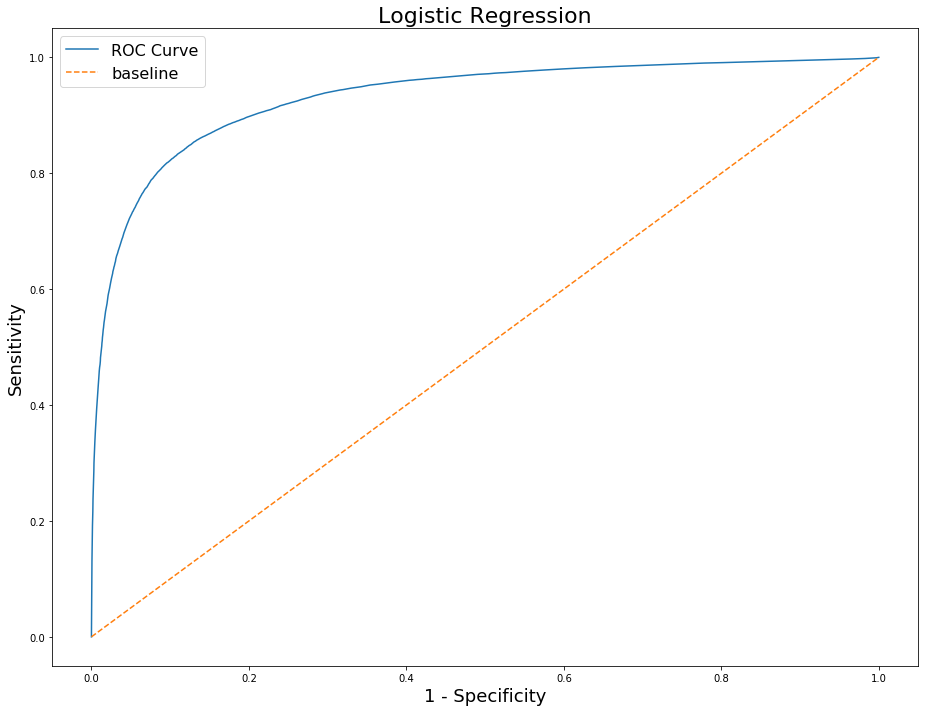

In [45]:
roc(lr, X_test, y_test, y_pred_lr, 'Logistic Regression')

#### Decision Tree Model
---
The next model attempt is the Decision Tree Model. From the looks of the score between test and train, it appears it performed slightly worse than the Logistic Model. The ROC curve also appears to be a bit more smooth than the Logistic Model but because of lower score, it might not be considered to be the model of choice. 

In [ ]:
dt_params = {'max_depth': [110], 
             'min_samples_split': [2], 
             'min_samples_leaf': [1]}

gs_dt = GridSearchCV(dt, param_grid = dt_params, cv = 5, n_jobs = -1)
gs_dt.fit(X_train, y_train)
gs_dt.best_params_

In [95]:
dt = DecisionTreeClassifier(max_depth=110)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)

print(f'The training data cross validation score is {cross_val_score(dt, X_train, y_train, cv = 5).mean()}.')
metrics(y_test, y_pred_dt, dt, X_test)

The training data cross validation score is 0.8933084730337477.
The accuracy for the test data for this model is 0.907
The misclassification for the test data for this model is: 0.093
The specificity for the test data for this model is: 0.907
The sensitivity for the test data for this model is: 0.908
The precision for the test data for this model is: 0.907


The area under the ROC curve is 0.907.


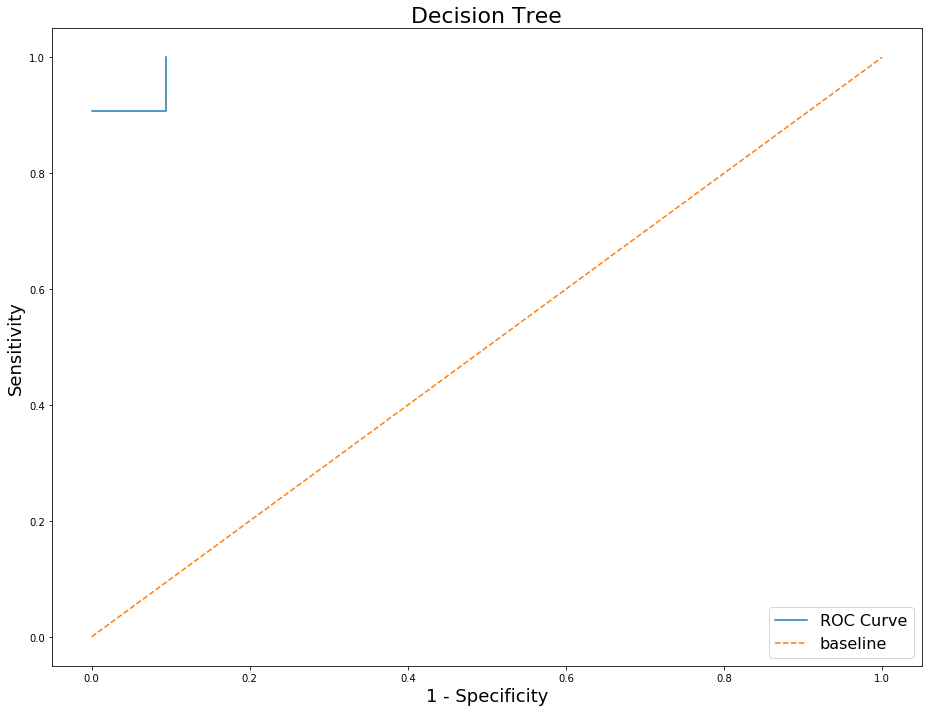

In [96]:
roc(dt, X_test, y_test, y_pred_dt, 'Decision Tree')

#### Random Forest Model
---
Random Forest performed quite exceptionally from the results. The score for both test and train were above the prior two models with the addition of a very smooth AOC curve as shown below. The "turn" of the curve is actually much more smooth than the models above and this looks be to the definitive model. We will attempt two more models below which are SVC and XGBoost to see if there are any improvements but because of the size of the data, it might not be efficient to run those model for moderate improvements. Nonetheless, we will observe how does the model perform.

In [ ]:
rf_params = {'n_estimators': [130],
             'max_depth': [70]}

gs_rf = GridSearchCV(rf, param_grid = rf_params, cv = 5, n_jobs = -1)
gs_rf.fit(X_train, y_train)
gs_rf.best_params_

In [99]:
rf = RandomForestClassifier(max_depth = 70, n_estimators = 130, n_jobs = -1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print(f'The training data score is {round(cross_val_score(rf, X_train, y_train, cv = 5).mean(), 4)}.')
metrics(y_test, y_pred_rf, rf, X_test)

The training data score is 0.9203.
The accuracy for the test data for this model is 0.933
The misclassification for the test data for this model is: 0.067
The specificity for the test data for this model is: 0.937
The sensitivity for the test data for this model is: 0.929
The precision for the test data for this model is: 0.937


The area under the ROC curve is 0.933.


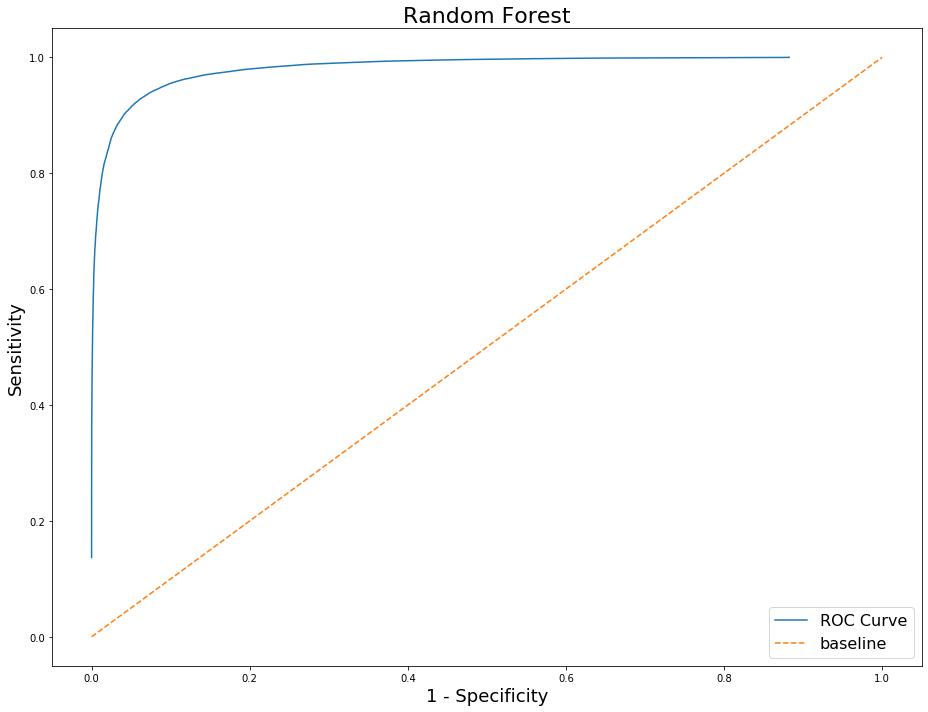

In [98]:
roc(rf, X_test, y_test, y_pred_rf, 'Random Forest')

#### Extreme Gradient Boost
---
The first model we want to explore is the simplest model with logistic regression. 

In [ ]:
xg_params = {'n_estimators': [140],
             'max_depth': [70]}

gs_xg = GridSearchCV(xg, param_grid = xg_params, cv = 5, n_jobs = -1)
gs_xg.fit(X_train, y_train)
gs_xg.best_params_

In [ ]:
xg = xgb.XGBClassifier(max_depth= 70, n_estimators = 140, n_jobs = -1)
xg.fit(X_train, y_train)

y_pred_xgb = xg.predict(X_test)

print(f'The test data cross validation score is {cross_val_score(xg, X_test, y_test, cv = 5).mean()}.')
metrics(y_test, y_pred_xgb, xg, X_test)  

In [ ]:
roc(xg, X_test, y_test, y_pred_xgb, 'Extreme Gradient Boost')

#### Neural Network with Keras
---
Because neural network type models are designed for large dataset, we want to explore how Keras perform with our analysis. For the network, we will instate an initial input layer with 512 nodes, 5 hidden layers with half of the nodes as the previous layer, then a final output layer utilization the sigmoid activation function since we are solving a binary classification problem. Each hidden nodes will employ the Rectified Linear Unit activation function. To prevent the possibility of high variance, we will drop 40% of the nodes at each layer in combination with a callback option to stop the model when a certain threshold of variance between the train and test data is reached.

In [142]:
drop_out = .4

model = Sequential()
model.add(Dense(512, input_dim = X_train_sc.shape[1], activation='relu'))
model.add(Dropout(drop_out))
model.add(Dense(256, activation='relu'))
model.add(Dropout(drop_out))
model.add(Dense(128, activation='relu'))
model.add(Dropout(drop_out))
model.add(Dense(64, activation='relu'))
model.add(Dropout(drop_out))
model.add(Dense(32, activation='relu'))
model.add(Dropout(drop_out))
model.add(Dense(16, activation='relu'))
model.add(Dropout(drop_out))
model.add(Dense(1, activation='sigmoid'))

In [143]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [144]:
hist = model.fit(X_train_sc, y_train, validation_data=(X_test_sc, y_test), epochs=150, batch_size=64, verbose=2, callbacks=[early_stop])

Train on 350234 samples, validate on 116745 samples
Epoch 1/150
 - 29s - loss: 0.3740 - acc: 0.8403 - val_loss: 0.3073 - val_acc: 0.8616
Epoch 2/150
 - 27s - loss: 0.3313 - acc: 0.8608 - val_loss: 0.3005 - val_acc: 0.8675
Epoch 3/150
 - 27s - loss: 0.3215 - acc: 0.8644 - val_loss: 0.3028 - val_acc: 0.8707
Epoch 4/150
 - 26s - loss: 0.3138 - acc: 0.8675 - val_loss: 0.2878 - val_acc: 0.8737
Epoch 5/150
 - 28s - loss: 0.3090 - acc: 0.8692 - val_loss: 0.2844 - val_acc: 0.8746
Epoch 6/150
 - 30s - loss: 0.3047 - acc: 0.8713 - val_loss: 0.2851 - val_acc: 0.8758
Epoch 7/150
 - 30s - loss: 0.3021 - acc: 0.8711 - val_loss: 0.2831 - val_acc: 0.8766
Epoch 8/150
 - 27s - loss: 0.3004 - acc: 0.8715 - val_loss: 0.2813 - val_acc: 0.8777
Epoch 9/150
 - 27s - loss: 0.2982 - acc: 0.8733 - val_loss: 0.2896 - val_acc: 0.8782
Epoch 10/150
 - 27s - loss: 0.2967 - acc: 0.8741 - val_loss: 0.2801 - val_acc: 0.8779
Epoch 11/150
 - 26s - loss: 0.2963 - acc: 0.8736 - val_loss: 0.2734 - val_acc: 0.8785
Epoch 12/15

The graph below shows that the model stopped at the 23rd epoch when the variance of testing and training data reached 0 at the 22nd epoch. The model has determined that this is the most ideal result and any further will not yield improvements to the model.

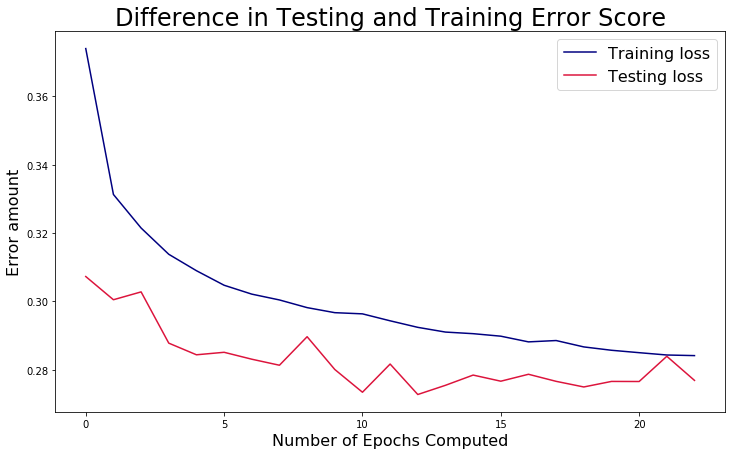

In [147]:
plt.figure(figsize=(12, 7))

plt.plot(hist.history['loss'], label='Training loss', color='navy')
plt.plot(hist.history['val_loss'], label='Testing loss', color='crimson')

plt.title('Difference in Testing and Training Error Score', fontsize = 24)

plt.xlabel('Number of Epochs Computed', fontsize = 16)
plt.ylabel('Error amount', fontsize = 16)

plt.legend(fontsize = 16);

Here we want to display the metrics of the results using neural networks. Because Keras and SKlearn are a bit different, we had to take out our usual metrics function and manually edit the variable and methods to get the correct value. The overall score is not as good as Random Forest with specificity showing an under

In [148]:
y_pred_ffnn = model.predict_classes(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_ffnn).ravel()
acc = hist.history['acc'][-1] 
mis = 1 - acc 
spec = tn / (tn+fp) 
sens = tp / (tp+fn) 
prec = tp / (tp+fp) 
print(f'The accuracy for the test data for this model is {round(acc,3)}')
print(f'The misclassification for the test data for this model is: {round(mis,3)}')
print(f'The specificity for the test data for this model is: {round(spec,3)}')
print(f'The sensitivity for the test data for this model is: {round(sens,3)}')
print(f'The precision for the test data for this model is: {round(prec,3)}')

The accuracy for the test data for this model is 0.879
The misclassification for the test data for this model is: 0.121
The specificity for the test data for this model is: 0.333
The sensitivity for the test data for this model is: 0.872
The precision for the test data for this model is: 0.568


Since neural network models have an output dimension of 1, it would only produce the probability of success. For our ROC curve, we need both the probability of failure and success in order for the plot to work. We created a loop that takes every value from the predictor and calculate the failure probability. Then we store the pair of values into a list.

In [157]:
pred_proba = model.predict_proba(X_test_sc)

pred_roc = []
for i in pred_proba:
    pred_roc.append([float(1-i), float(i)])

In [ ]:
Similar 

The area under the ROC curve is 0.882.


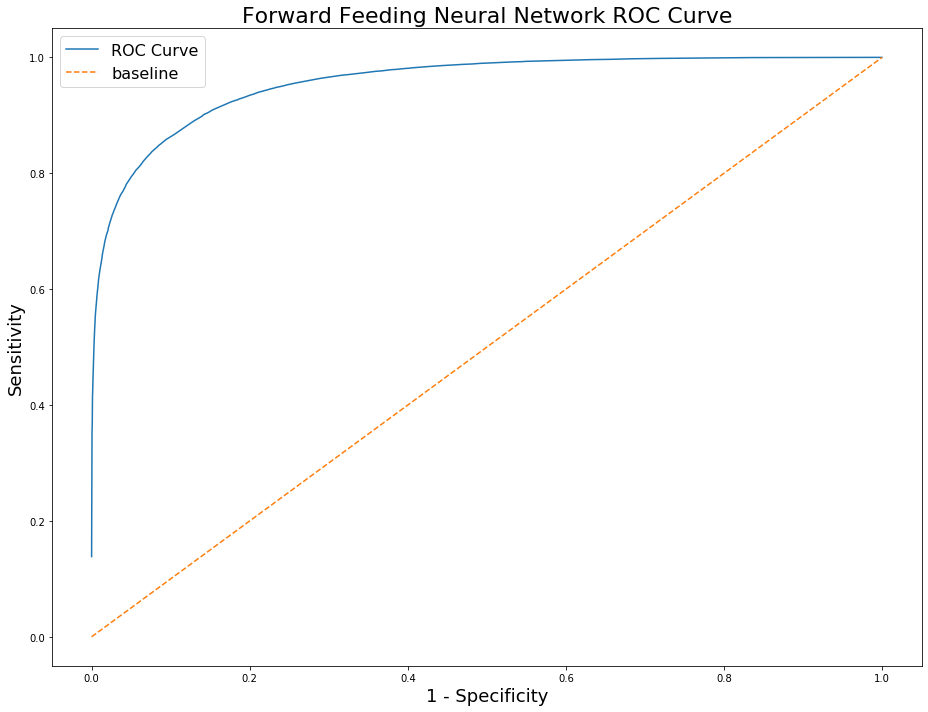

In [165]:
model_prob = [i[1] for i in pred_roc]
model_pred_df = pd.DataFrame({'true_values': y_test,
                                    'pred_probs':model_prob})

thresholds = np.linspace(0, 1, 400) # 400 steps of floating points (decimals) between 0 and 1. This is a placeholder for 
                                    # probability as it starts from 0 and slowly approaches 1. We will use these numbers as
                                    # a guide to see how the number of predicted values change as we move closer to 1.

# For this particular function, it calculates the value of sensitivity at a particular point along the threshold values.
# Since each point of threshold presents the probability of that instance, the true positive rate should decrease as the 
# strictness increases. Therefore, there is an inverse relationship between higher threshold and the amount of true positives
# present.
def true_positive_rate(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)

# This function shows the false positive rate which is expressed as 1 - Specificity. We want to see how that rate changes
# as specificity increases toward 1 along with sensitivity.
def false_positive_rate(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))

# We want to store the sensitivity values and 1 - specificity values in 2 different lists. We can compare these value
# point-for-point on a line graph so show their relationship. 
tpr_values = [true_positive_rate(model_pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [false_positive_rate(model_pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]


# below we set the parameters for the chart size as well as figures for plotting. The main variables are False Positive 
# Rate and the True Positive Rate plotted as a line. The x-axis will be represented by 1 - specificity to show the 
# relationship as sensitivity increases, what happens to specificity.
plt.figure(figsize = (13,10))
plt.plot(fpr_values, 
         tpr_values, 
         label='ROC Curve')

plt.plot(np.linspace(0, 1, 400),
         np.linspace(0, 1, 400),
         label='baseline',
         linestyle='--')


plt.title('Forward Feeding Neural Network ROC Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)


plt.legend(fontsize=16)

plt.tight_layout()
#     plt.savefig(f'../graphs/{str(filename)}.png'); #saves the 

print(f'The area under the ROC curve is {round(roc_auc_score(y_test, model.predict_classes(X_test_sc)), 3)}.')

### Results

From the models above, it appears that Random Forest had the best result with little variance as a bonus. 

In [114]:
important_features = pd.DataFrame(list(rf.feature_importances_), columns= ['features'],index = X.columns)

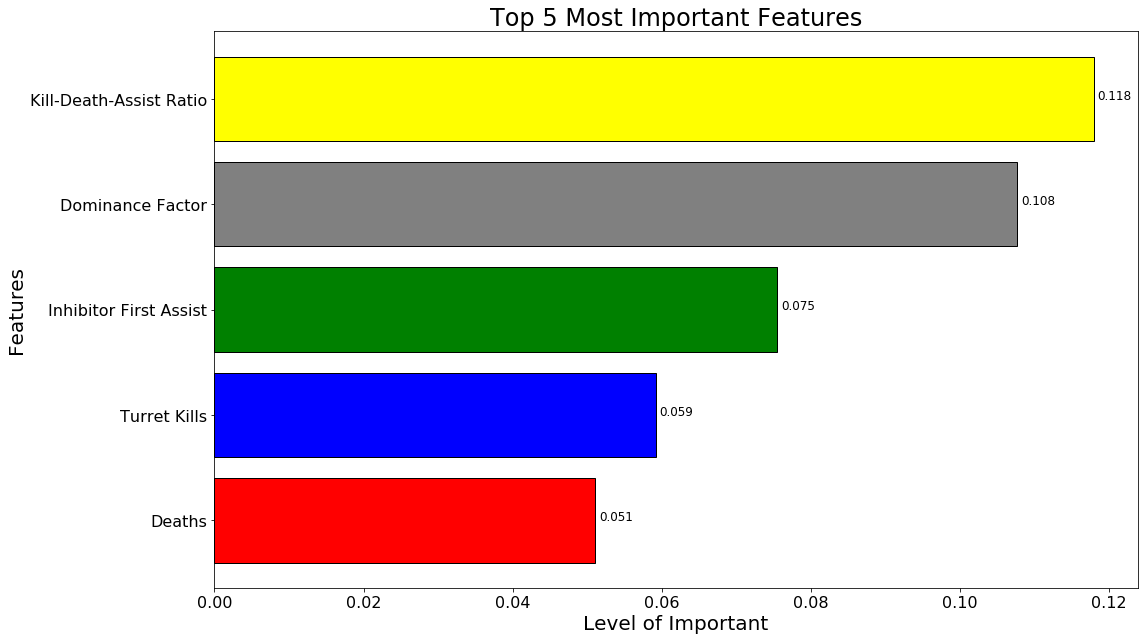

In [166]:
plt.figure(figsize = (16,9))

features_location = important_features['features'].sort_values(ascending = False).head(5).sort_values().index
plt.barh(important_features['features'].sort_values(ascending = False).head(5).sort_values().index, 
         important_features['features'].sort_values(ascending = False).head(5).sort_values(), 
         color = ['red', 'blue', 'green', 'gray', 'yellow'], 
         edgecolor = 'black')

plt.yticks(np.arange(5), 
           ['Deaths', 
            'Turret Kills', 
            'Inhibitor First Assist', 
            'Dominance Factor', 
            'Kill-Death-Assist Ratio'], fontsize = 16)
plt.xticks(fontsize = 16)

for i in features_location:
    plt.text(important_features['features'].sort_values(ascending = False).head(5).sort_values()[i] + .0005, 
                   i,
                   str(round(important_features['features'].sort_values(ascending = False).head(5).sort_values()[i], 3)), 
                   fontsize = 12)

plt.title('Top 5 Most Important Features', fontsize = 24)
plt.xlabel('Level of Important', fontsize = 20)
plt.ylabel('Features', fontsize = 20)

plt.tight_layout();

## Conclusion